## Preprocessing and merging

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
import anndata
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%pwd

'/ihome/ylee/yiz133/Code/Scirpy/scripy'

In [3]:
mdata = mu.read("./data/common_GEX_TCR_mdata.h5mu")
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [4]:
common_cells = mdata.mod["gex"].obs.index.intersection(mdata.mod["airr"].obs.index)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()
tcr_subset = mdata.mod["airr"][common_cells, :].copy()
# Create a new MuData object to preserve alignment
mdata_new = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_new.obs = mdata.obs.loc[mdata_new.mod["gex"].obs.index]

# Verify the new object
print(mdata_new)

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'


In [5]:
types = mdata_new.obs['sample']
category_counts = types.value_counts()
category_counts


sample
SPL_0605    31628
SPL_0516    28337
CNS_0605    15058
CNS_0516     2637
Name: count, dtype: int64

## drop Treg transfer samples

In [6]:
# exclude 2D2 transfer samples

selected_samples_id = ["CMO301", "CMO302", "CMO318", "CMO325"]
selected_date = ["0516"]
selected_tissue = ["CN"]

mdata = mdata[~ (mdata.mod["gex"].obs["mouse_id"].isin(selected_samples_id) & mdata.mod["gex"].obs["date"].isin(selected_date))]

# positive select
mdata = mdata[ mdata.mod["gex"].obs["date"].isin(["0605"]) ]

mdata

View of MuData object with n_obs × n_vars = 46686 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample'
  2 modalities
    gex:	46686 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	46686 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [7]:
IDs = mdata.mod["gex"].obs['tissue']
counts = IDs.value_counts()
counts

tissue
SP    31628
CN    15058
Name: count, dtype: int64

In [8]:
# mu.pp.filter_obs(mdata, "sample", lambda x: np.isin(x, ["CNS_0605", "SPL_0605"]))
# mu.pp.filter_obs(mdata, "manual_cell_type", lambda x: np.isin(x, ["CD4+ T", "Treg", "CD8+ T"]))

mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
mdata.obs["celltype_sample"] = (
    mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
)


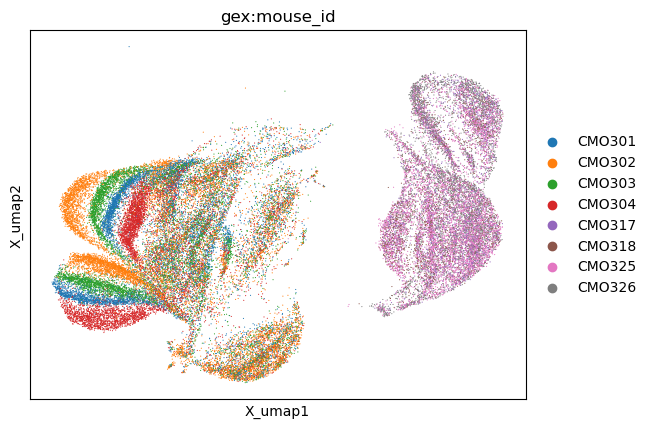

In [9]:
selected_samples = ["SPL_0605", "CNS_0605"]  # List of categories to keep
# , "CNS_0605"
mdata_subset = mdata[mdata.obs["sample"].isin(selected_samples)].copy()
mu.pl.embedding(mdata_subset, basis="gex:umap", color=['gex:mouse_id'],wspace = 0.2)


In [10]:
mdata.obs.to_csv("strict_filtered_meta.csv")

# Extract TCR seq

In [11]:
col1 = ir.get.airr(mdata, "cdr3_aa", "VDJ_1")
col2 = ir.get.airr(mdata, "v_call", "VDJ_1")

In [12]:
TCR_DF = pd.concat([col1], axis = 1)
TCR_DF = TCR_DF.dropna()
TCR_DF

,0
cell_id,
AAACCAAAGCGTTGAC-1_0605_CNS,TCSDWGGAETLY
AAACCAAAGCTAGTGC-1_0605_CNS,ASSPNGGANQNTLY
AAACCAAAGCTCGAGT-1_0605_CNS,ASSDNFSNERLF
AAACCAAAGGTCCTAA-1_0605_CNS,ASRGGLGDYEQY
AAACCAGCAAGTAACG-1_0605_CNS,ASGDAGDQAPL
...,...
GTTGTGGGTGGAGCGA-1_0605_SPL,GARDINERLF
GTTGTGGGTGGATCGC-1_0605_SPL,AWRVSTEVF
GTTGTGGGTGGCTGTA-1_0605_SPL,ASSLDLGGDQDTQY


In [13]:
# TCR_DF.to_csv('output.txt', header=True, index=True)

### Additional prefiltering - filter out "orphan VDJ", "orphan VJ"

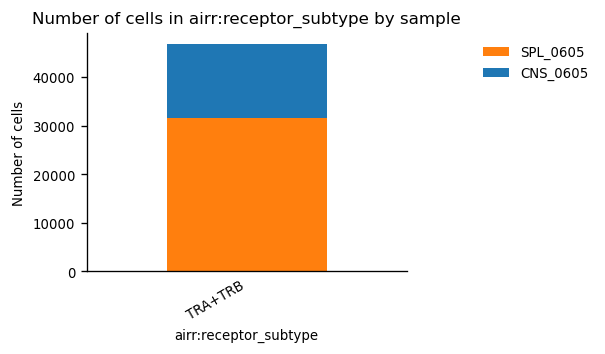

In [14]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="sample")

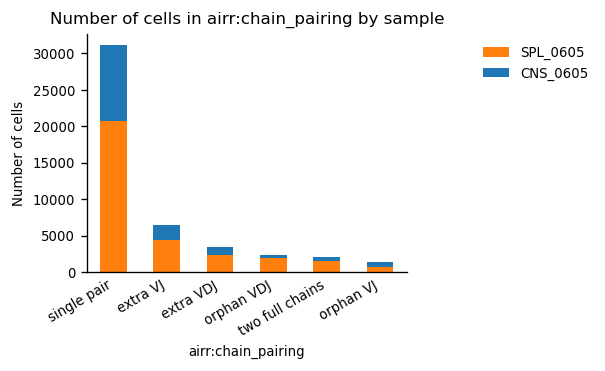

In [15]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="sample")

In [16]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.25


In [17]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, []))
mdata.mod["airr"].obs["chain_pairing"]

selected_chains = ["orphan VDJ", "orphan VJ"]  # List of categories to keep
mdata_filtered = mdata[~mdata.mod["airr"].obs["chain_pairing"].isin(selected_chains)].copy()


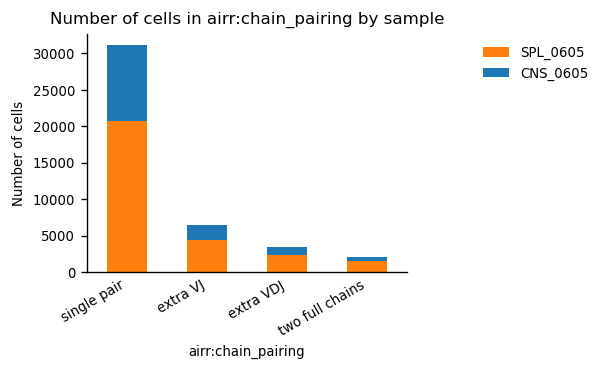

In [18]:
ax = ir.pl.group_abundance(mdata_filtered, groupby="airr:chain_pairing", target_col="sample")

## Clonotype

### Apply TCRDist for clusering the TCRs and also obtain clonotype_network

In [19]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
# metric = 'tcrdist'

# by nucleotide acid seq
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")
ir.tl.clonotype_network(mdata, min_cells=10)
#_ = ir.pl.clonotype_network(mdata, color="sample", base_size=20, label_fontsize=9, panel_size=(10,10))

In [20]:
## recompute clonotype based aa seq
ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

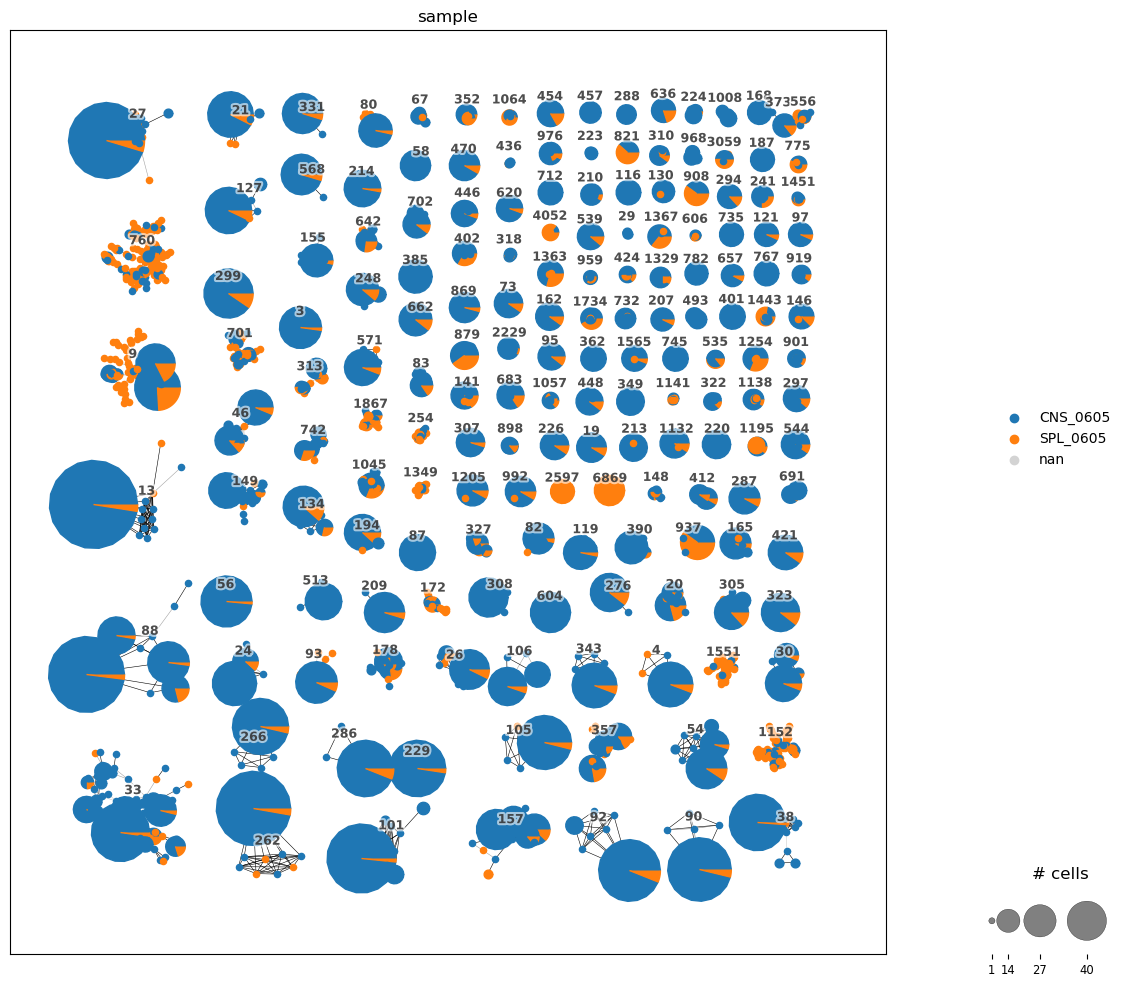

In [21]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")
ir.tl.clonotype_network(mdata, min_cells=15, sequence="aa", metric="tcrdist")
_ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(12,12), base_size=20)

In [22]:
mdata

MuData object with n_obs × n_vars = 46686 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'celltype_sample'
  uns:	'sample_colors'
  2 modalities
    gex:	46686 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	46686 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'cc_aa_tcrdist', 'cc_aa_tcrdist_size'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network', 'ir_dist_aa_tcrdist', 'cc_aa_tcrdist'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

In [23]:
mdata['airr'].obs['clone_id_size']

cell_id
AAACCAAAGATGCCCG-1_0605_CNS     1
AAACCAAAGCGTTGAC-1_0605_CNS     1
AAACCAAAGCTAGTGC-1_0605_CNS     1
AAACCAAAGCTCGAGT-1_0605_CNS    46
AAACCAAAGGTCCTAA-1_0605_CNS    53
                               ..
GTTGTGGGTGGAGCGA-1_0605_SPL     1
GTTGTGGGTGGATCGC-1_0605_SPL     1
GTTGTGGGTGGCTGTA-1_0605_SPL     1
GTTGTGGGTGTCCCTG-1_0605_SPL     1
GTTGTGGGTGTTACCC-1_0605_SPL     1
Name: clone_id_size, Length: 46686, dtype: int64

In [24]:
# ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="VDJ", dual_ir="primary_only")
# ir.tl.clonotype_network(mdata, min_cells=10, sequence="aa", metric="tcrdist")
# _ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(12, 12), base_size=20)

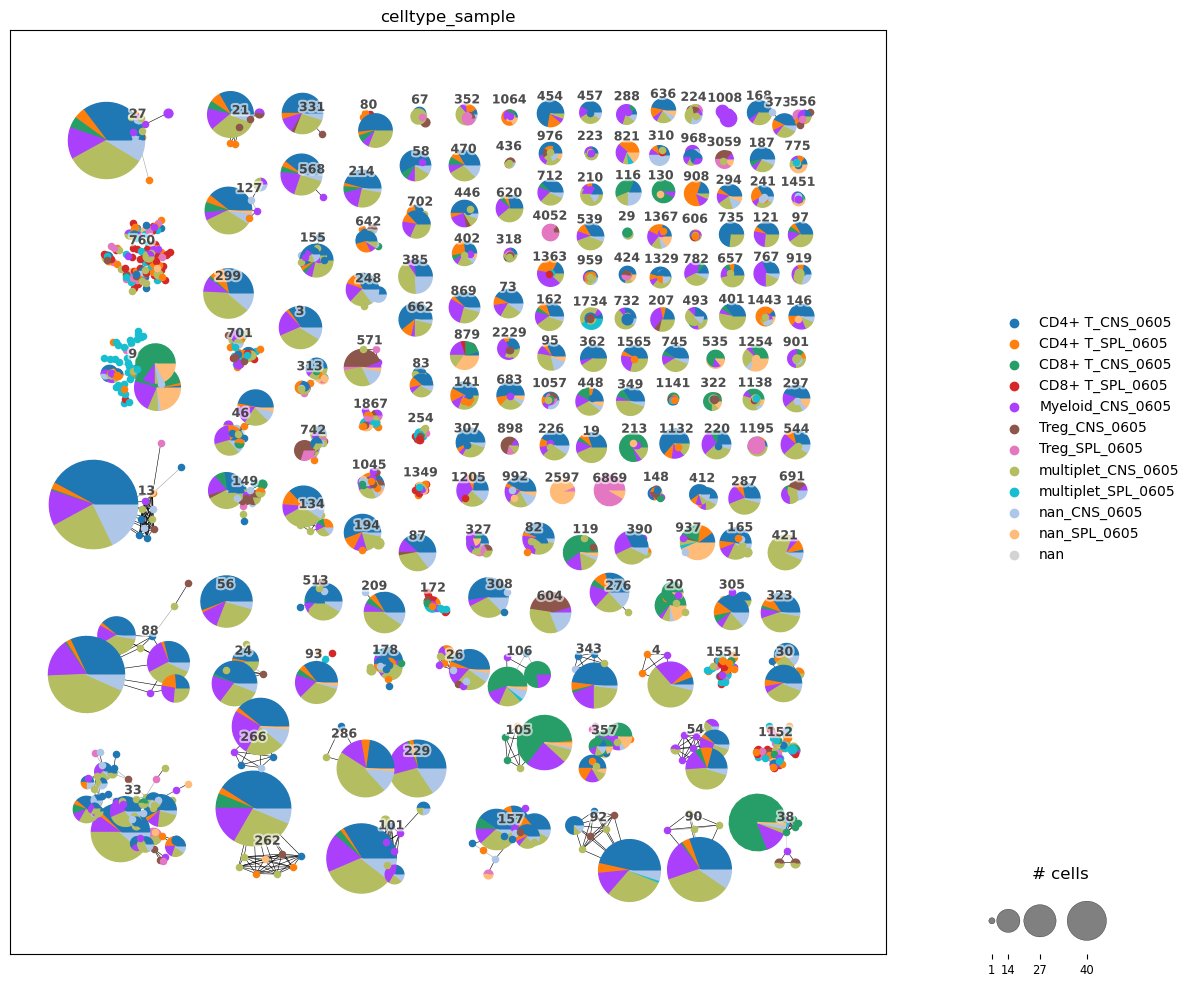

In [25]:
_ = ir.pl.clonotype_network(mdata, color="celltype_sample", label_fontsize=9, panel_size=(12, 12), base_size=20)


### Clonotype modularity

The clonotype modularity measures how densely connected the transcriptomics neighborhood graph underlying the cells in a clonotype is. Clonotypes with a high modularity consist of cells that are **transcriptionally more similar** than that of a clonotype with a low modularity. CNS has higher clonotype modularity than spleen.

In [26]:
#
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

  0%|          | 0/32725 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

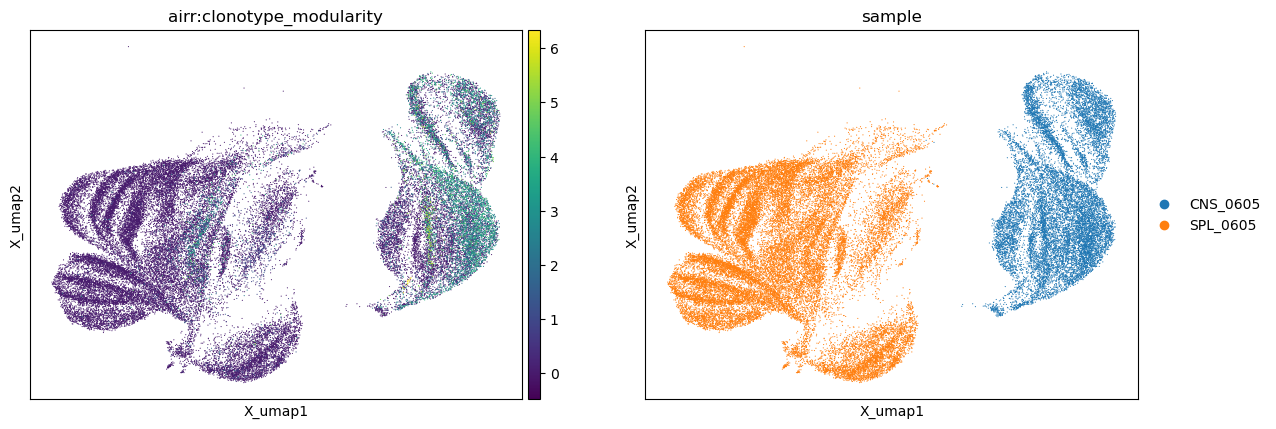

In [27]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonotype_modularity","sample"])

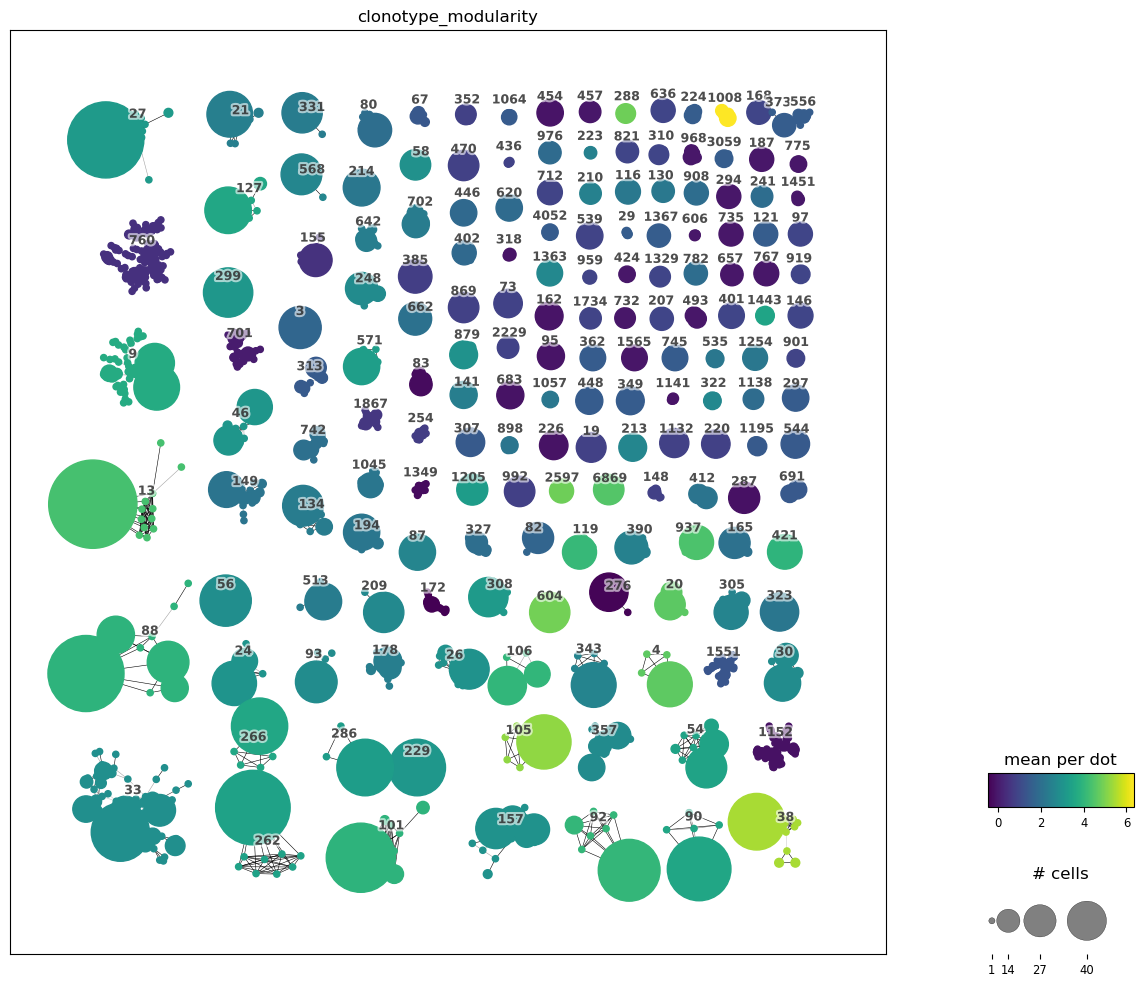

In [28]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(12, 12),
    base_size=20,
)


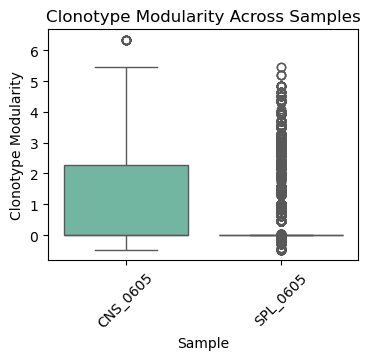

In [29]:
import seaborn as sns
import pandas as pd
mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# Extract relevant data from mdata_new
df_plot = mdata.obs[["airr:clonotype_modularity", "sample"]].dropna()

# Convert to DataFrame
df_plot = df_plot.astype({"airr:clonotype_modularity": float})

# Create the boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(data=df_plot, x="sample", y="airr:clonotype_modularity", palette="Set2")

plt.xlabel("Sample")
plt.ylabel("Clonotype Modularity")
plt.title("Clonotype Modularity Across Samples")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()

### Clonal expansion

CNS has a larger proportion of cells with ≥5 cells sharing the same clone compared to the spleen.

In [30]:
ir.tl.clonal_expansion(mdata)

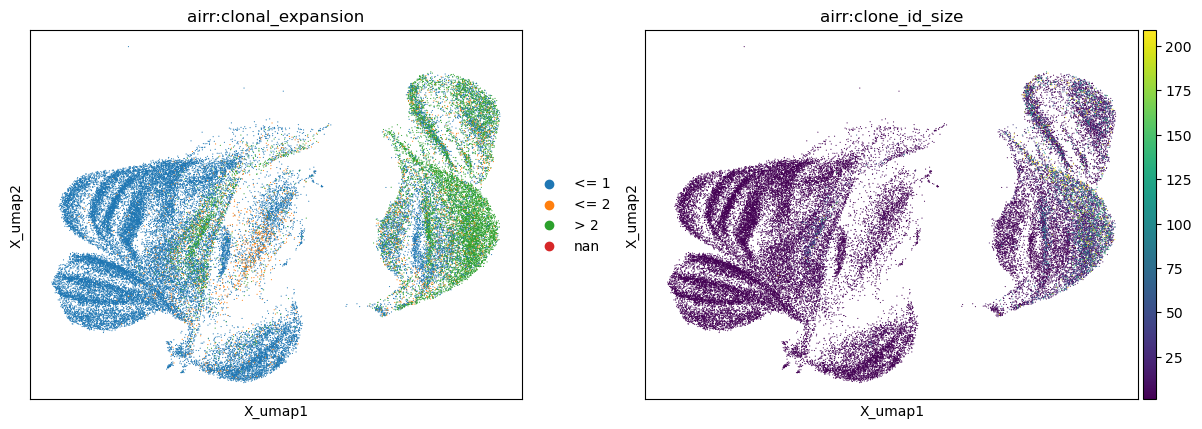

In [31]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"])

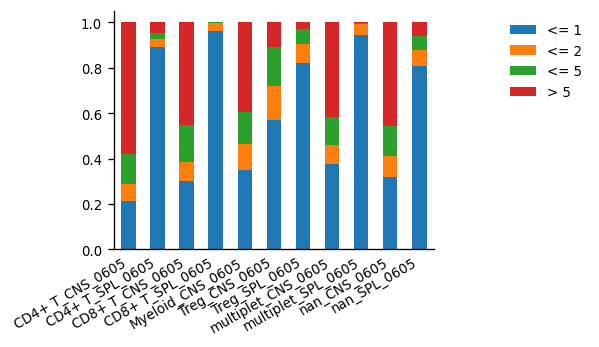

In [32]:
# Perform clonal expansion analysis
_ = ir.pl.clonal_expansion(
    mdata, 
    target_col="clone_id", 
    groupby="celltype_sample",  # Use the new combined column
    breakpoints=(1, 2, 5), 
    #normalize=False
)


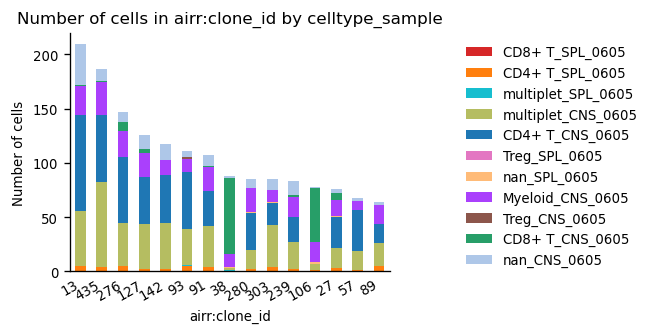

In [33]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="celltype_sample",
    max_cols=15,
    #normalize="manual_cell_type",
)

### Motif

Slightly different motif for Treg_CNS_0605 cells and Treg_Spleen_0605 cells

In [34]:
mdata.obs["celltype_sample"].unique()

['Treg_CNS_0605', 'CD4+ T_CNS_0605', 'multiplet_CNS_0605', 'Myeloid_CNS_0605', 'nan_CNS_0605', ..., 'Treg_SPL_0605', 'CD8+ T_SPL_0605', 'nan_SPL_0605', 'multiplet_SPL_0605', 'CD4+ T_SPL_0605']
Length: 11
Categories (11, object): ['CD4+ T_CNS_0605', 'CD4+ T_SPL_0605', 'CD8+ T_CNS_0605', 'CD8+ T_SPL_0605', ..., 'multiplet_CNS_0605', 'multiplet_SPL_0605', 'nan_CNS_0605', 'nan_SPL_0605']

In [35]:
ir.get.airr(mdata, "junction_aa", "VDJ_1")

cell_id
AAACCAAAGATGCCCG-1_0605_CNS                None
AAACCAAAGCGTTGAC-1_0605_CNS      CTCSDWGGAETLYF
AAACCAAAGCTAGTGC-1_0605_CNS    CASSPNGGANQNTLYF
AAACCAAAGCTCGAGT-1_0605_CNS      CASSDNFSNERLFF
AAACCAAAGGTCCTAA-1_0605_CNS      CASRGGLGDYEQYF
                                     ...       
GTTGTGGGTGGAGCGA-1_0605_SPL        CGARDINERLFF
GTTGTGGGTGGATCGC-1_0605_SPL         CAWRVSTEVFF
GTTGTGGGTGGCTGTA-1_0605_SPL    CASSLDLGGDQDTQYF
GTTGTGGGTGTCCCTG-1_0605_SPL        CASGSKNTEVFF
GTTGTGGGTGTTACCC-1_0605_SPL        CASSLGQTEVFF
Length: 46686, dtype: object

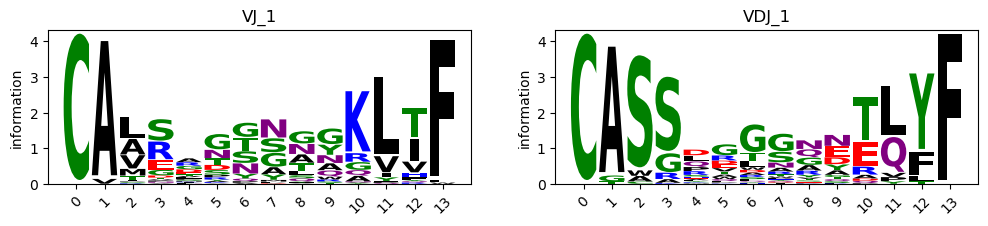

In [36]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata[
            (mdata.obs["celltype_sample"] == "Treg_CNS_0605")
            & (ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

In [37]:
temp = mdata_filtered.obs["celltype_sample"] 
# == "Treg_Spleen_0605"
temp.value_counts()

celltype_sample
CD8+ T_SPL_0605       9638
CD4+ T_SPL_0605       9266
multiplet_CNS_0605    4393
multiplet_SPL_0605    3956
CD4+ T_CNS_0605       3590
Treg_SPL_0605         3084
nan_SPL_0605          3064
Myeloid_CNS_0605      2401
Treg_CNS_0605         1366
CD8+ T_CNS_0605       1176
nan_CNS_0605          1054
Name: count, dtype: int64

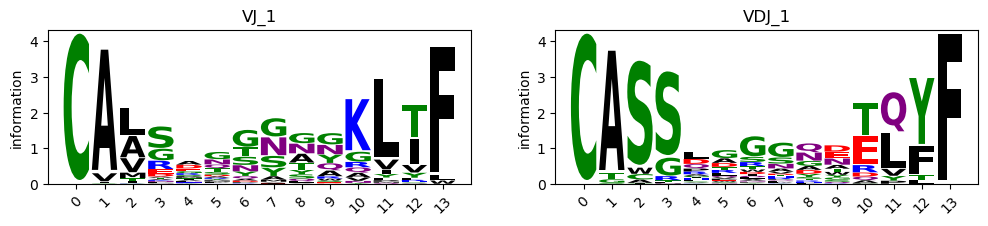

In [38]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata_filtered[
            (mdata_filtered.obs["celltype_sample"] == "Treg_SPL_0605")
            & (ir.get.airr(mdata_filtered, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata_filtered, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

### DE analysis for high modularity clusters - mostly from CNS

In [39]:
# mdata.obs['celltype_sample']
# mdata_ori = mdata

# selected_samples_id = ["CD4+ T_CNS_0605"]
# # "CD8+ T_CNS_0605"

# mdata_DE = mdata[(mdata.obs['celltype_sample'].isin(selected_samples_id))]

# mdata = mdata_DE

In [40]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_tcrdist")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:10]
)


In [41]:
clonotypes_top_modularity #['107'-CD8_cns, '41'-CD8_cns, '287' - Treg_cns, '3' - CD4_cns, '9'-CD8_cns, '161'-CD8_cns, '49'-CD8_cns, '44'- CD4_cns, '3346'-Treg_spleen, '72'-CD4_cns]

['1008', '38', '105', '604', '2597', '288', '4', '20', '6869', '937']

In [42]:
# mdata.write("filtered_mdata.h5mu")

In [43]:
mdata.mod["airr"].obs["clonotype_modularity"].sort_values(ascending=False).index.unique().values[:10]

array(['CATGGATGTGTCCGGG-1_0605_CNS', 'AGTGGGCAGCAGTCTA-1_0605_CNS',
       'AGTGAGAGTGGTCAAT-1_0605_CNS', 'CCCATGGAGCGTAATT-1_0605_CNS',
       'CACAATTAGAGTTTCG-1_0605_CNS', 'ACAGTCTCACAGCACC-1_0605_CNS',
       'GCAGGGTAGAGTAAGC-1_0605_CNS', 'CGTTACTTCATGAGTT-1_0605_CNS',
       'ACTAATCAGCGATTGC-1_0605_CNS', 'CCTACCATCATACGCA-1_0605_CNS'],
      dtype=object)

In [44]:
mdata["gex"].X

<46686x33708 sparse matrix of type '<class 'numpy.float32'>'
	with 108150503 stored elements in Compressed Sparse Row format>

In [45]:
prefixes_to_remove = ('Tra', 'Trb', 'CMO', 'ENSM') 
mask = ~ mdata["gex"].var_names.str.startswith(prefixes_to_remove)

gex_TCR_filtered = mdata["gex"][:, mask]
gex_TCR_filtered

View of AnnData object with n_obs × n_vars = 46686 × 33161
    obs: 'mouse_id', 'date', 'tissue'
    uns: 'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap', 'sample_colors', 'airr:clonal_expansion_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

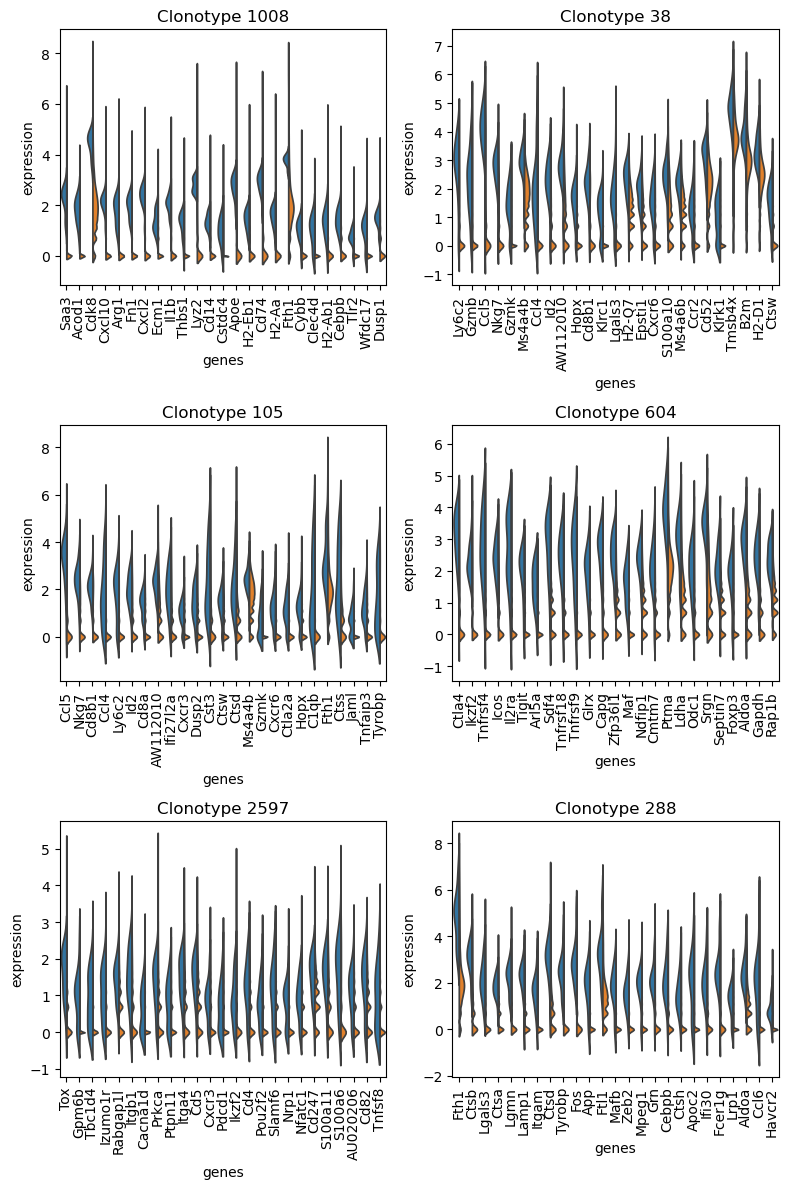

In [46]:
# List of clonotypes to analyze
clonotypes_top_modularity_for_CNS = clonotypes_top_modularity[:6]

# Set up the context for ranking genes based on clonotype modularity
with ir.get.obs_context(gex_TCR_filtered, {"cc_aa_tcrdist": mdata.obs["airr:cc_aa_tcrdist"]}) as tmp_ad:
    # Perform differential expression analysis using Wilcoxon test
    sc.tl.rank_genes_groups(
        tmp_ad,
        "cc_aa_tcrdist",
        groups = clonotypes_top_modularity_for_CNS,
        reference= "rest",
        method="wilcoxon"
    )
    
    # top_gene_list=tmp_ad.uns['rank_genes_groups']['names']

    # Dynamically determine the number of rows/columns for subplots
    num_clonotypes = len(clonotypes_top_modularity_for_CNS)
    num_cols = 2  # Number of columns in the figure
    num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))  
    axs = axs.flatten()  # Flatten in case of multiple rows

    # Generate violin plots for each clonotype
    for ct, ax in zip(clonotypes_top_modularity_for_CNS, axs):
        sc.pl.rank_genes_groups_violin(tmp_ad, groups=[ct], n_genes=25, ax=ax, show=False, strip=False)
        ax.set_title(f"Clonotype {ct}")  # Add title to each subplot

    # Remove any unused subplots
    for i in range(len(clonotypes_top_modularity_for_CNS), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

In [47]:
tmp_ad.uns['rank_genes_groups']['names'][0:20]

rec.array([('Saa3', 'Ly6c2', 'Ccl5', 'Ctla4', 'Tox', 'Fth1'),
           ('Acod1', 'Gzmb', 'Nkg7', 'Ikzf2', 'Gpm6b', 'Ctsb'),
           ('Cdk8', 'Ccl5', 'Cd8b1', 'Tnfrsf4', 'Tbc1d4', 'Lgals3'),
           ('Cxcl10', 'Nkg7', 'Ccl4', 'Icos', 'Izumo1r', 'Ctsa'),
           ('Arg1', 'Gzmk', 'Ly6c2', 'Il2ra', 'Rabgap1l', 'Lgmn'),
           ('Fn1', 'Ms4a4b', 'Id2', 'Tigit', 'Itgb1', 'Lamp1'),
           ('Cxcl2', 'Ccl4', 'Cd8a', 'Arl5a', 'Cacna1d', 'Itgam'),
           ('Ecm1', 'Id2', 'AW112010', 'Sdf4', 'Prkca', 'Ctsd'),
           ('Il1b', 'AW112010', 'Ifi27l2a', 'Tnfrsf18', 'Ptpn11', 'Tyrobp'),
           ('Thbs1', 'Hopx', 'Cxcr3', 'Tnfrsf9', 'Itga4', 'Fos'),
           ('Lyz2', 'Cd8b1', 'Dusp2', 'Glrx', 'Cd5', 'App'),
           ('Cd14', 'Klrc1', 'Cst3', 'Capg', 'Cxcr3', 'Ftl1'),
           ('Cstdc4', 'Lgals3', 'Ctsw', 'Zfp36l1', 'Pdcd1', 'Mafb'),
           ('Apoe', 'H2-Q7', 'Ctsd', 'Maf', 'Ikzf2', 'Zeb2'),
           ('H2-Eb1', 'Epsti1', 'Ms4a4b', 'Ndfip1', 'Cd4', 'Mpeg1'),
         

In [48]:
a = tmp_ad.uns['rank_genes_groups']['names'][0:20].tolist()

In [49]:
com_genes = pd.DataFrame(a)
com_genes

,0,1,2,3,4,5
0,Saa3,Ly6c2,Ccl5,Ctla4,Tox,Fth1
1,Acod1,Gzmb,Nkg7,Ikzf2,Gpm6b,Ctsb
2,Cdk8,Ccl5,Cd8b1,Tnfrsf4,Tbc1d4,Lgals3
3,Cxcl10,Nkg7,Ccl4,Icos,Izumo1r,Ctsa
4,Arg1,Gzmk,Ly6c2,Il2ra,Rabgap1l,Lgmn
5,Fn1,Ms4a4b,Id2,Tigit,Itgb1,Lamp1
6,Cxcl2,Ccl4,Cd8a,Arl5a,Cacna1d,Itgam
7,Ecm1,Id2,AW112010,Sdf4,Prkca,Ctsd
8,Il1b,AW112010,Ifi27l2a,Tnfrsf18,Ptpn11,Tyrobp
9,Thbs1,Hopx,Cxcr3,Tnfrsf9,Itga4,Fos


In [50]:
common = set(com_genes[com_genes.columns[0]])
for col in com_genes.columns[1:2]:
    common &= set(com_genes[col])
print(common)

set()


## DE analysis for largest clonotypes

In [66]:
mask_cloned = mdata["airr"].obs["clone_id_size"] >= 2

cloned_cells = mdata[ mask_cloned]

cloned_cells

View of MuData object with n_obs × n_vars = 12951 × 33708
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num', 'sample', 'celltype_sample'
  uns:	'sample_colors', 'celltype_sample_colors', 'clonotype_modularity'
  2 modalities
    gex:	12951 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'airr:receptor_type_colors', 'gex:tissue_colors', 'log1p', 'manual_cell_type_colors', 'neighbors', 'pca', 'umap', 'sample_colors', 'airr:clonal_expansion_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    airr:	12951 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'cc_aa_tcrdist', 'cc_aa_tcrdist_size', 'clonotype_modularity', 'clonotype_modularity_fdr', 'clonal_expansion'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clone_id', 'clonotype_network', 'ir_dist_aa_tcrdist', 'cc_aa_tcrdist'
      obsm:	'airr', 'chain_indices', 'X_clonotype_network'

In [67]:
# cloned_cells.write("cloned_cells.h5mu")